In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Enter the full path of the directory to save the plots: /content/drive/MyDrive/ML Project
Plots will be saved in: /content/drive/MyDrive/ML Project

--- 1. Data Loading (Raw Train Data) ---
Loaded raw data from current directory.
Initial training data shape: (1200, 80)

--- 2. Outlier Removal ---
Rows removed due to extreme outliers: 9

--- 3. Feature Merging (Keeping Originals) ---
Merging basement features...
Engineering Pool features...
Merging porch features...
Dropping only essential columns (Id)...
Training data shape after merging/minimal dropping: (1191, 84)

--- 4. Target Transformation ---
Applied log1p transformation to target variable.

--- 5. Feature Engineering (Keeping Originals) ---
Applied feature engineering steps (keeping originals).
Final training features shape for analysis: (1191, 101)

--- 6. Correlation Analysis (All Features vs HotelValue_Log) ---

['ZoningCategory', 'RoadType', 'ServiceLaneType', 'PlotShape', 'LandElevation', 'UtilityAccess', 'PlotConfiguratio

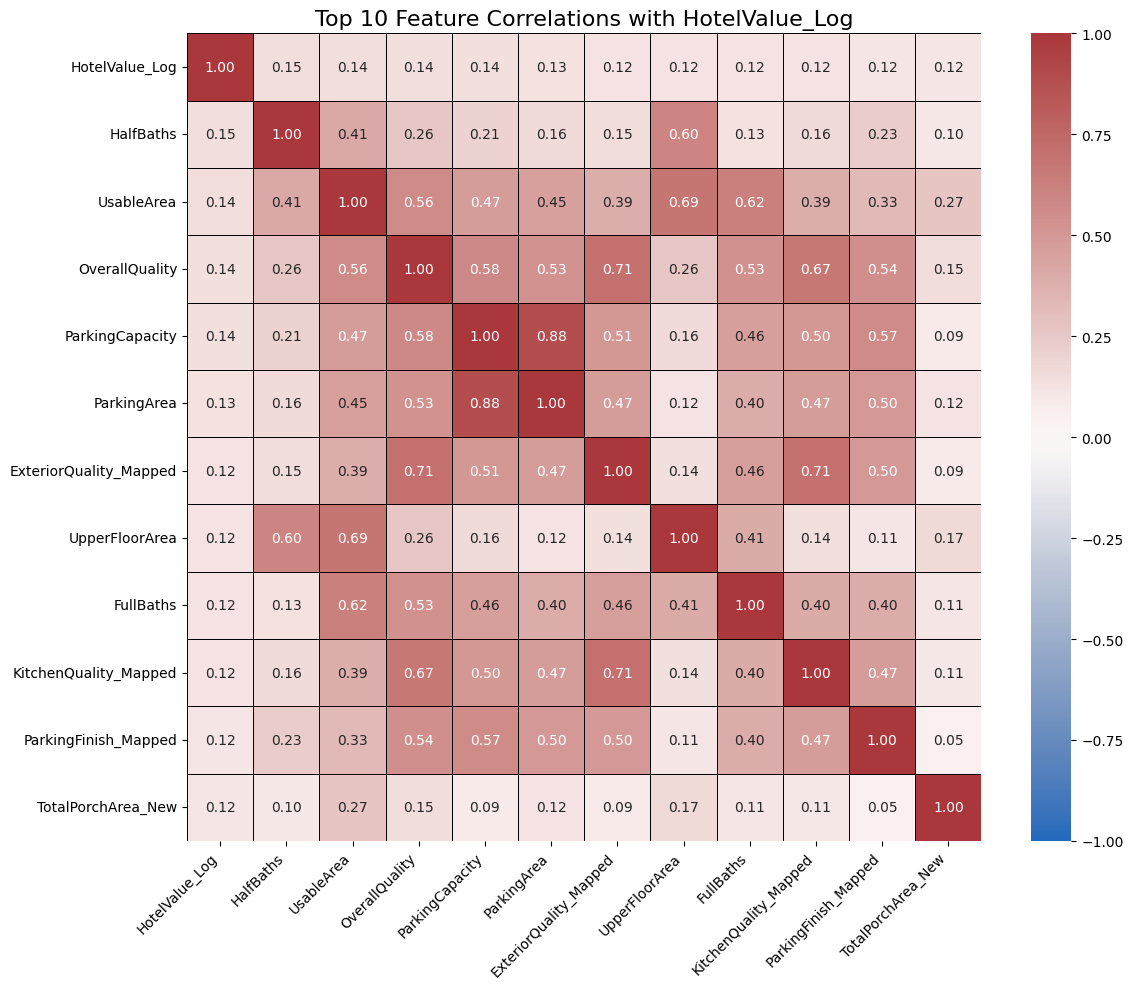

Successfully saved Top 10 correlation plot to /content/drive/MyDrive/ML Project/correlation_heatmap_top10.png

--- Script Finished ---


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Imports needed for preprocessing steps if run standalone
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
# Define file paths for RAW data
train_data_path = '/content/drive/MyDrive/ML Project/train.csv'
TARGET_COLUMN = 'HotelValue'
TARGET_COLUMN_LOG = 'HotelValue_Log' # Name for the transformed target

# 2. Get the directory to save plots
output_dir = input("Enter the full path of the directory to save the plots: ").strip()
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved in: {output_dir}")

# --- 1. Data Loading and Initial Setup ---
print("\n--- 1. Data Loading (Raw Train Data) ---")
try:
    df_train_raw = pd.read_csv('Hotel-Property-Value-Dataset/train.csv')
    print("Loaded raw data from 'Hotel-Property-Value-Dataset/' folder.")
except FileNotFoundError:
    try:
        df_train_raw = pd.read_csv(train_data_path)
        print("Loaded raw data from current directory.")
    except FileNotFoundError as e:
        print(f"Error: Raw files not found. Ensure '{train_data_path}' is in the correct location.")
        print(f"Details: {e}")
        raise
except Exception as e:
     print(f"An error occurred loading the CSV: {e}")
     raise

# Separate features and target
X_train_raw = df_train_raw.drop(columns=[TARGET_COLUMN], errors='ignore')
y_train_raw = df_train_raw[TARGET_COLUMN]

print(f"Initial training data shape: {X_train_raw.shape}")

# --- 2. Outlier Removal ---
print("\n--- 2. Outlier Removal ---")
initial_row_count = len(df_train_raw)

# 1. Target-based cleaning
y_lower_bound = y_train_raw.quantile(0.001)
y_upper_bound = y_train_raw.quantile(0.999)
outlier_mask = (y_train_raw >= y_lower_bound) & (y_train_raw <= y_upper_bound)

# 2. Predictor-based cleaning
if 'UsableArea' in X_train_raw.columns:
    outlier_mask &= (X_train_raw['UsableArea'] < 4000)
if 'OverallQuality' in X_train_raw.columns and 'UsableArea' in X_train_raw.columns:
    outlier_mask &= ~((X_train_raw['OverallQuality'] < 3) )

# Apply the mask
X_train = X_train_raw[outlier_mask].copy()
y_train = y_train_raw[outlier_mask].copy() # y_train is the cleaned, original target

print(f"Rows removed due to extreme outliers: {initial_row_count - len(X_train)}")

# --- 3. Feature Merging (Keeping Originals) ---
print("\n--- 3. Feature Merging (Keeping Originals) ---")
basement_quality_map = { 'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0 }
df_list = [X_train] # Only process train data

# Merge Basement
print("Merging basement features...")
for df in df_list:
    bsmt_sf1 = df['BasementFacilitySF1'].fillna(0)
    bsmt_sf2 = df['BasementFacilitySF2'].fillna(0)
    type1_score = df['BasementFacilityType1'].fillna('None').map(basement_quality_map).fillna(0)
    type2_score = df['BasementFacilityType2'].fillna('None').map(basement_quality_map).fillna(0)
    df['TotalBasementScore_New'] = (type1_score * bsmt_sf1) + (type2_score * bsmt_sf2)
    df['BasementFinishedSF_New'] = bsmt_sf1 + bsmt_sf2
    df['BasementAvgQuality_New'] = 0.0
    mask_has_finished = df['BasementFinishedSF_New'] > 0
    df.loc[mask_has_finished, 'BasementAvgQuality_New'] = (
        df.loc[mask_has_finished, 'TotalBasementScore_New'] / df.loc[mask_has_finished, 'BasementFinishedSF_New']
    ).fillna(0)

# Merge Pool
print("Engineering Pool features...")
pool_quality_map = { 'None': 0, 'Fa': 1, 'Ex': 2 }
for df in df_list:
    pool_area = df['SwimmingPoolArea'].fillna(0)
    pool_quality_score = df['PoolQuality'].fillna('None').map(pool_quality_map).fillna(0)
    df['TotalPoolScore_New'] = pool_quality_score * pool_area

# Merge Porch
print("Merging porch features...")
for df in df_list:
    df['TotalPorchArea_New'] = (
        df['OpenVerandaArea'].fillna(0)+
        df['EnclosedVerandaArea'].fillna(0) +
        df['SeasonalPorchArea'].fillna(0) +
        df['ScreenPorchArea'].fillna(0)
    )

# Initial Column Dropping (Only essential drops like ID)
print("Dropping only essential columns (Id)...")
columns_to_drop_minimal = ['Id'] # Only drop ID for correlation
X_train = X_train.drop(columns=columns_to_drop_minimal, errors='ignore')

print(f"Training data shape after merging/minimal dropping: {X_train.shape}")

# --- 4. Target Transformation ---
print("\n--- 4. Target Transformation ---")
y_train_log = np.log1p(y_train) # <-- Log transform is back
print("Applied log1p transformation to target variable.")


# --- 5. Feature Engineering Function (Keeping Originals) ---
print("\n--- 5. Feature Engineering (Keeping Originals) ---")
def engineer_features_keep_originals(df):
    df = df.copy()
    quality_map_5pt = { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 }
    parking_finish_map = { 'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 }
    functionality_map = { 'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'None': 0 }
    exposure_map = { 'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0 }

    # Create NEW columns for Ordinal Mappings
    df['ParkingQuality_Mapped'] = df['ParkingQuality'].fillna('None').map(quality_map_5pt).fillna(0)
    df['ParkingCondition_Mapped'] = df['ParkingCondition'].fillna('None').map(quality_map_5pt).fillna(0)
    df['ParkingFinish_Mapped'] = df['ParkingFinish'].fillna('None').map(parking_finish_map).fillna(0)
    df['ExteriorQuality_Mapped'] = df['ExteriorQuality'].fillna('None').map(quality_map_5pt).fillna(0)
    df['ExteriorCondition_Mapped'] = df['ExteriorCondition'].fillna('None').map(quality_map_5pt).fillna(0)
    df['BasementCondition_Mapped'] = df['BasementCondition'].fillna('None').map(quality_map_5pt).fillna(0)
    df['BasementExposure_Mapped'] = df['BasementExposure'].fillna('None').map(exposure_map).fillna(0)
    df['KitchenQuality_Mapped'] = df['KitchenQuality'].fillna('None').map(quality_map_5pt).fillna(0)
    df['HeatingQuality_Mapped'] = df['HeatingQuality'].fillna('None').map(quality_map_5pt).fillna(0)
    df['PropertyFunctionality_Mapped'] = df['PropertyFunctionality'].fillna('None').map(functionality_map).fillna(0)
    df['BasementHeight_Mapped'] = df['BasementHeight'].fillna('None').map(quality_map_5pt).fillna(0)

    # Create NEW Time-based features
    if 'YearSold' in df.columns and 'ConstructionYear' in df.columns:
        df['HouseAge_New'] = df['YearSold'] - df['ConstructionYear']
    if 'RenovationYear' in df.columns and 'ConstructionYear' in df.columns and 'YearSold' in df.columns:
        temp_reno = df['RenovationYear'].fillna(df['ConstructionYear'])
        temp_reno.loc[temp_reno == 0] = df.loc[temp_reno == 0, 'ConstructionYear']
        df['YearsSinceModification_New'] = df['YearSold'] - pd.concat([df['ConstructionYear'], temp_reno], axis=1).max(axis=1)

    # Create NEW Log transformation features
    log_cols_orig = ['ParkingConstructionYear','BasementFinishedSF','YearsSinceModification','LandArea', 'BasementTotalSF', 'ParkingArea']
    for col in log_cols_orig:
        if col in df.columns:
            # Check if new version of source exists (e.g., BasementFinishedSF_New)
            new_col_name = col + '_New'
            log_col_name = col + '_Log'

            if new_col_name in df.columns: # e.g., BasementFinishedSF_New
                temp_df = df[new_col_name].fillna(0)
                df[new_col_name + '_Log'] = np.log1p(temp_df) # e.g., BasementFinishedSF_New_Log
            elif col in df.columns: # e.g., LandArea
                temp_df = df[col].fillna(0)
                df[log_col_name] = np.log1p(temp_df) # e.g., LandArea_Log

    # --- NO DROPPING of originals ---
    return df

# Apply feature engineering to X_train
X_train_fe = engineer_features_keep_originals(X_train)
print("Applied feature engineering steps (keeping originals).")
print(f"Final training features shape for analysis: {X_train_fe.shape}")

# --- 6. Correlation Analysis (All Features vs LOG-TRANSFORMED HotelValue) ---
print(f"\n--- 6. Correlation Analysis (All Features vs {TARGET_COLUMN_LOG}) ---")

# 1. Create a temporary DataFrame for correlation
df_for_corr = X_train_fe.copy()

# 2. Add the LOG-TRANSFORMED target variable
df_for_corr[TARGET_COLUMN_LOG] = y_train_log.reset_index(drop=True) # <-- Use y_train_log

# 3. Identify and drop ONLY non-numeric columns (original categoricals)
non_numeric_cols = df_for_corr.select_dtypes(exclude=np.number).columns.tolist()
if len(non_numeric_cols) > 0:
    print(f"\nWarning: Dropping non-numeric features for correlation matrix:")
    print(non_numeric_cols)
    df_for_corr = df_for_corr.drop(columns=non_numeric_cols)
else:
    print("\nAll features seem numerical. Proceeding with correlation.")

# Ensure target column is numeric before calculating correlation
df_for_corr[TARGET_COLUMN_LOG] = pd.to_numeric(df_for_corr[TARGET_COLUMN_LOG], errors='coerce')
df_for_corr = df_for_corr.dropna(subset=[TARGET_COLUMN_LOG]) # Drop rows if target became NaN

# 4. Calculate the correlation matrix
print("\nCalculating correlation matrix...")
corr_matrix = df_for_corr.corr()

# 5. Extract correlations with the target and sort
if TARGET_COLUMN_LOG in corr_matrix:
    # Use abs() to get magnitude, then sort, then retrieve original values
    corr_with_target_abs_sorted = corr_matrix[TARGET_COLUMN_LOG].abs().sort_values(ascending=False)
    # Re-order the original correlation series based on the absolute sorted index
    corr_with_target_sorted = corr_matrix[TARGET_COLUMN_LOG].loc[corr_with_target_abs_sorted.index]

    corr_with_target_sorted = corr_with_target_sorted.dropna() # Drop NaNs
else:
    print(f"Error: Target column '{TARGET_COLUMN_LOG}' not found in correlation matrix columns.")
    corr_with_target_sorted = pd.Series()

# 6. Print the top 10 (including target itself) with names and values
print(f"\n--- Top 10 Features Correlated with {TARGET_COLUMN_LOG} (Positive or Negative) ---")
top_10 = corr_with_target_sorted.head(11) # +1 to include target itself
print(top_10)

# 7. Print the correlation values for the remaining features
if len(corr_with_target_sorted) > 11:
    print(f"\n--- Correlation Values for Remaining {len(corr_with_target_sorted) - 11} Features ---")
    remaining_correlations = corr_with_target_sorted[11:]
    with pd.option_context('display.max_rows', None):
        print(remaining_correlations.round(4).to_string())
else:
    print("\nFewer than 10 features available after dropping non-numeric columns.")

# 8. Generate and save the heatmap plot for Top 10 vs LOG HotelValue
print("\nGenerating and saving correlation heatmap for Top 10 features...")
if not corr_with_target_sorted.empty and len(corr_with_target_sorted) > 1:
    # Get the names of the top 10 features (index[0] is the target itself)
    top_10_features = corr_with_target_sorted[1:12].index.tolist()
    cols_to_plot = [TARGET_COLUMN_LOG] + top_10_features # Use LOG target column name

    # Filter the original correlation matrix to only these columns/rows
    corr_matrix_top_10 = corr_matrix.loc[cols_to_plot, cols_to_plot]

    try:
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            corr_matrix_top_10,
            annot=True, cmap='vlag', vmin=-1, vmax=1, fmt='.2f',
            linewidths=.5, linecolor='black'
        )
        plt.title(f'Top 10 Feature Correlations with {TARGET_COLUMN_LOG}', fontsize=16) # Use LOG target name
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        plot_filename = os.path.join(output_dir, 'correlation_heatmap_top10.png') # New filename
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Successfully saved Top 10 correlation plot to {plot_filename}")

    except Exception as e:
        print(f"Could not generate Top 10 plot: {e}")
else:
    print("Could not generate Top 10 plot: Not enough features or target correlation unavailable.")


print("\n--- Script Finished ---")